In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from ssa import *

from darts import TimeSeries
from darts.models import LinearRegressionModel
from darts.metrics import mape, rmse
import pandas as pd
import numpy as np
from darts import TimeSeries
from darts.models import LinearRegressionModel
from darts.dataprocessing.transformers import Scaler
from darts.utils.missing_values import extract_subseries
import matplotlib.pyplot as plt


In [3]:
data = pd.read_parquet("../data/afrr_price.parquet")

In [4]:
data = data[['wind_offshore_dayahead', 'wind_onshore_dayahead',
       'solar_dayahead','aFRR_DownCapPriceEUR', 'aFRR_UpCapPriceEUR', 'load_forecasts',
       'da_price', 'prod_unbalance']]

In [5]:
ts = data["aFRR_UpCapPriceEUR"]
ssa_ts = mySSA(data["aFRR_UpCapPriceEUR"])
ssa_ts.embed(embedding_dimension=128, suspected_frequency=24, verbose=True)
ssa_ts.decompose(True)
components = [i for i in range(10)]
ts_clean = ssa_ts.view_reconstruction(*[ssa_ts.Xs[i] for i in components], names=components, return_df=True, plot=False)

----------------------------------------
EMBEDDING SUMMARY:
Embedding dimension	:  120
Trajectory dimensions	: (120, 3265)
Complete dimension	: (120, 3265)
Missing dimension     	: (120, 0)
----------------------------------------
DECOMPOSITION SUMMARY:
Rank of trajectory		: 120
Dimension of projection space	: 113
Characteristic of projection	: 0.9997


In [6]:
data["aFRR_UpCapPriceEUR_cl"] = ts_clean.values

In [7]:


target_col = 'aFRR_UpCapPriceEUR_cl'
exog_cols = ['wind_offshore_dayahead', 'wind_onshore_dayahead', 
             'solar_dayahead', 'load_forecasts', 'da_price', 'prod_unbalance']

# Create TimeSeries objects
target_series = TimeSeries.from_series(data[target_col], freq="1h")
covariates = TimeSeries.from_dataframe(data[exog_cols], freq="1h")

# Extract subseries without missing values
target_subseries = extract_subseries(
    series=target_series,
    min_gap_size=1
)

covariates_subseries = extract_subseries(
    series=covariates,
    min_gap_size=1,
    mode='all'
)

target_clean = max(target_subseries, key=len)
covariates_clean = max(covariates_subseries, key=len)

start_time = max(target_clean.start_time(), covariates_clean.start_time())
end_time = min(target_clean.end_time(), covariates_clean.end_time())

target_final = target_clean.slice(start_time, end_time)
covariates_final = covariates_clean.slice(start_time, end_time)

print(f"Clean aligned series length: {len(target_final)}")

train_cutoff = int(len(target_final) * 0.3)
train_target = target_final[:train_cutoff]
test_target = target_final[train_cutoff:]

max_past_lag = 24  # Assuming your longest past lag is 24

train_covariates = covariates_final[:train_cutoff]
test_covariates_start = train_cutoff - max_past_lag
test_covariates = covariates_final[test_covariates_start:]

# Scale the data
scaler_target = Scaler()
scaler_covariates = Scaler()
train_target_scaled = scaler_target.fit_transform(train_target)
train_covariates_scaled = scaler_covariates.fit_transform(train_covariates)
test_covariates_scaled = scaler_covariates.transform(test_covariates)

The provided DatetimeIndex was associated with a timezone, which is currently not supported by xarray. To avoid unexpected behaviour, the tz information was removed. Consider calling `ts.time_index.tz_localize(UTC)` when exporting the results.To plot the series with the right time steps, consider setting the matplotlib.pyplot `rcParams['timezone']` parameter to automatically convert the time axis back to the original timezone.
The provided DatetimeIndex was associated with a timezone, which is currently not supported by xarray. To avoid unexpected behaviour, the tz information was removed. Consider calling `ts.time_index.tz_localize(UTC)` when exporting the results.To plot the series with the right time steps, consider setting the matplotlib.pyplot `rcParams['timezone']` parameter to automatically convert the time axis back to the original timezone.


Clean aligned series length: 1223


In [13]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import warnings

import matplotlib.pyplot as plt

from darts.dataprocessing.transformers import Scaler
from darts.datasets import AirPassengersDataset
from darts.metrics import mape
from darts.models import (
    ExponentialSmoothing,
    KalmanForecaster,
    LinearRegressionModel,
    NaiveDrift,
    NaiveEnsembleModel,
    NaiveSeasonal,
    RandomForest,
    RegressionEnsembleModel,
    TCNModel,
)
from darts.utils.timeseries_generation import (
    datetime_attribute_timeseries as dt_attr,
)

warnings.filterwarnings("ignore")

import logging

logging.disable(logging.CRITICAL)

In [14]:
candidates_models = {
    "LinearRegression": (LinearRegressionModel, {"lags": list(range(-1, -24, -1))}),
    "ExponentialSmoothing": (ExponentialSmoothing, {}),
    "KalmanForecaster": (KalmanForecaster, {"dim_x": 12}),
    "RandomForest": (RandomForest, {"lags": 12, "random_state": 0}),
}

In [ ]:
backtest_models = []

for model_name, (model_cls, model_kwargs) in candidates_models.items():
    model = model_cls(**model_kwargs)
    backtest_models.append(
        model.historical_forecasts(ts_clean, start=0.6, forecast_horizon=3)
    )
    print(f"{model_name} MAPE: {round(mape(backtest_models[-1], ts_air), 5)}")

In [12]:
from darts.models import RegressionModel
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from darts.models import RegressionModel, AutoARIMA
from darts.models import NaiveEnsembleModel

regression_model = RegressionModel(
    lags=list(range(-1, -24, -1)), 
    lags_past_covariates=list(range(-1, -6, -1)),
    lags_future_covariates=list(range(1,10,1)),  
    output_chunk_length=24,
    likelihood="quantile",
    quantiles=[0.05, 0.5, 0.95],
    model=Ridge()
)




TypeError: RegressionModel.__init__() got an unexpected keyword argument 'likelihood'

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`start` position `1` corresponding to time `2025-01-16 07:00:00` is before the first predictable/trainable historical forecasting point for series at index: 0. Using the first historical forecasting point `2025-01-18 07:00:00` that lies a round-multiple of `stride=24` ahead of `start`. To hide these warnings, set `show_warnings=False`.


historical forecasts:   0%|          | 0/33 [00:00<?, ?it/s]

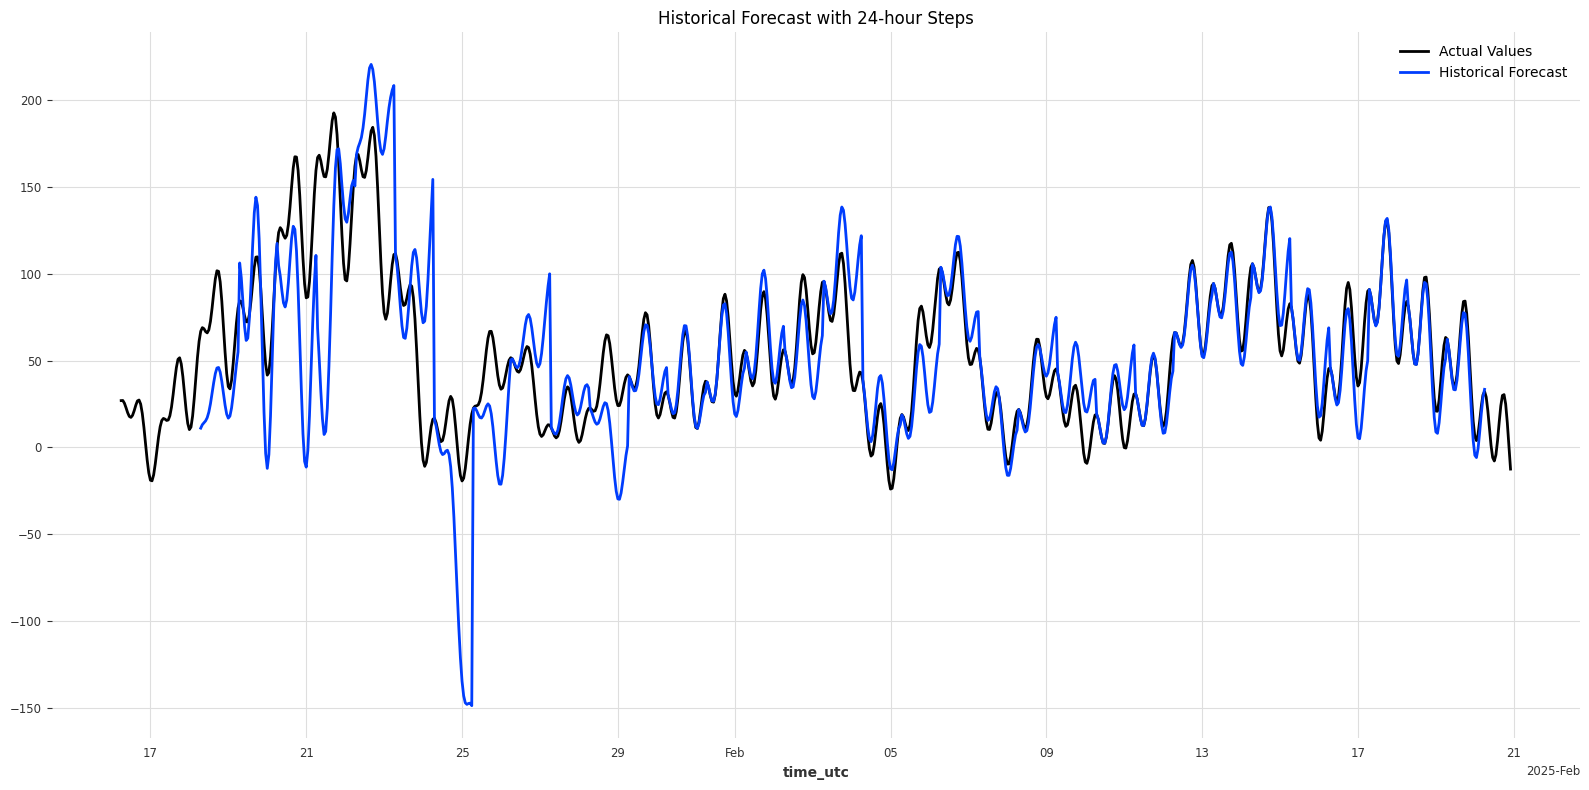

In [19]:
forecast_horizon = 24  # How far ahead to predict
stride = 24            # Step size for rolling window (24 hours as requested)
start_idx = forecast_horizon  # Start after first forecast horizon to ensure enough history

backtest_forecasts = model.historical_forecasts(
    series=test_target,
    past_covariates=test_covariates,  # Use test_covariates instead
    future_covariates=test_covariates,  # Use test_covariates instead
    start=1,  
    forecast_horizon=forecast_horizon,
    stride=stride,
    retrain=True,
    last_points_only=False,  # Keep all forecasts
    verbose=True
)

# Combine forecasts to create a continuous prediction
if len(backtest_forecasts) > 0:
    
    combined_forecast = backtest_forecasts[0]
    for i in range(1, len(backtest_forecasts)):
        combined_forecast = combined_forecast.concatenate(backtest_forecasts[i])

    # Plot results
    plt.figure(figsize=(16, 8))
    test_target.plot(label='Actual Values', lw=2)
    combined_forecast.plot(label='Historical Forecast', lw=2)
    plt.title('Historical Forecast with 24-hour Steps')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Calculate metrics on the forecasted period
    forecast_period = test_target.slice(
        combined_forecast.start_time(),
        combined_forecast.end_time()
    )

